# MST Vincolato
Dato un grafo non orientato e non completo, e dato un nodo r, si determini l’albero di copertura di radice r che minimizza il numero di figli di ogni nodo -1 (dato un albero di copertura, orientato a partire dalla radice, ogni nodo i non foglia ha ki ≥ 1 figli. Si minimizza la somma su tutti i nodi i non foglia di ki-1)

In [53]:
import os
import networkx as nx
import matplotlib.pyplot as plt

In [54]:
# PARAMETRI GENERALI
OUT_DIR = "out" # dove salvare i disegni dei grafi (x debug)

ROOT_NODE = 5
MAX_NODES = 46
GRAPH_GENERATOR = "CUSTOM" # [NX_ATLAS | NX_COMPLETE_GRAPH | CUSTOM ]

### Inizializzazione

In [55]:
# CREAZIONE GRAFO e strutture

# TODO importa grafo da file


# Grafo di test
if not "GRAPH_GENERATOR" in globals() or GRAPH_GENERATOR == "CUSTOM":
    print("[INFO] Uso generatore mio")
    G = nx.Graph()
    G.add_nodes_from([
        x for x in range(1, MAX_NODES+1)
    ])

    G.add_edges_from([
        (x,y) for x in range(1, MAX_NODES+1)
            for y in range(x+1, MAX_NODES+1)
    ])

    # Rendiamo il grafo non completo
    G.remove_edges_from([ (1,4), (3,6), (5,3), (4,5)])
    G.remove_edges_from([ 
        (a,b) for a in range(MAX_NODES, int(MAX_NODES/2))
              for b in range(1,MAX_NODES-1) if (b+a) %3 != 0
     ])
else :
    match GRAPH_GENERATOR:
        case "NX_ATLAS": 
            # generatore "atlas" di networkx
            # non sono grafi molto densi, e sono piccoli
            # 666
            # 420
            # 969
            # 1196
            atlas_num = 969
            print("[INFO] Uso generatore nx.atlas (seed={})".format(atlas_num))
            G = nx.graph_atlas(atlas_num)
        case "NX_COMPLETE_GRAPH":
            print("[INFO] Uso generatore grafo completo (n={})".format(MAX_NODES))
            G = nx.complete_graph(range(1,MAX_NODES+1))
        case _:
            # robetta semplice
            atlas_num = 1234
            print("[WARN] Generatore non valido, uso grafo di test (nx.atlas, id=1234)")
            G = nx.graph_atlas(atlas_num)

# Prepara directory in cui salvare i rendering
OUT_DIR = os.path.join(os.getcwd(),OUT_DIR)
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

[INFO] Uso generatore mio


In [56]:
# Alcune funzioni di supporto

def draw_graph(graph, MST=nx.empty_graph(), root_node=None):
    # adapted from:
    # https://stackoverflow.com/questions/60164893/highlighting-certain-nodes-edges-in-networkx-issues-with-using-zip

    nodes_shared_options = {"node_size": 500, "edgecolors": "black", "linewidths": 1.2}
    edges_shared_options = {"connectionstyle": 'arc3', "width": 1.25} 
    
    # Get position using spring layout
    pos = nx.spring_layout(graph, seed=54321)
    #pos = nx.circular_layout(graph)

    # Get MST path
    path_edges = list(MST.edges)

    # Prepare the figure size
    plt.figure(figsize=(max(8,MAX_NODES/6),max(8,MAX_NODES/6)))

    # Draw nodes and edges not included in the MST path
    #nx.draw_networkx_nodes(graph, pos, nodelist=set(graph.nodes)-set(MST.nodes))
    nx.draw_networkx_nodes(graph, pos, nodelist=graph.nodes, node_color="whitesmoke", **nodes_shared_options)
    nx.draw_networkx_edges(graph, pos, edgelist=set(graph.edges)-set(path_edges), edge_color='gray', **edges_shared_options )

    # Draw MST path
    # highlight the root node
    if root_node != None:
        nx.draw_networkx_nodes(graph, pos, nodelist=[root_node], node_color='tab:red', **nodes_shared_options)

    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', **edges_shared_options)

    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_color='black', font_weight='bold')
    nx.draw_networkx_labels(graph, pos, labels={root_node: root_node}, font_color='whitesmoke', font_weight='bold')



def save_figure(name, format="svg"):
    filename = "{}.{}".format(name,format)
    plt.tight_layout(pad=1)
    plt.savefig(os.path.join(OUT_DIR,filename), bbox_inches='tight', format=format, dpi=800, transparent=True)



In [57]:
# Funzione obiettivo

def cost(MST, root_node, debug=False):

    support_graph = nx.Graph()

    visited = set()
    next = [root_node]
    
    cost = 0

    while len(next) > 0:
        node = next.pop(0)
        node_edges = MST.edges(node)
        
        if node not in visited:
            k_children = len( [ x for x in node_edges if x not in support_graph.edges ] )

            if debug:
                print("node {} has {} children".format(node, k_children))

            if k_children > 1:
                cost += k_children - 1

            visited.add(node)
            next = next + list(MST.adj[node])
            support_graph.add_edges_from(node_edges)
        
    return cost


node 1 has 2 children
node 2 has 3 children
node 6 has 0 children
node 3 has 0 children
node 5 has 0 children
node 4 has 0 children
cost:  3


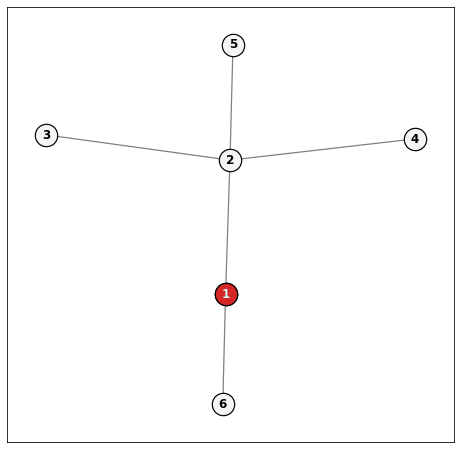

In [58]:
# TEST cost() children nodes
TEST = nx.Graph()
TEST.add_edges_from([(1, 2), (2, 3), (2, 5), (1, 6), (2, 4)])

TEST_ROOT = 1

draw_graph(TEST, root_node=TEST_ROOT)

print("cost: ",cost(TEST, 1,debug=True))

## Ricerca Locale

In [59]:
# PARAMETRI RICERCA
MAX_ITER = 36000    # Criterio di stop: arresta la ricerca dopo queste iterazioni (es. se il grafo è troppo grosso)
DEBUG_IMPROVEMENT = False
SAVE_STEP_GRAPHS = False

### 1. Creazione soluzione ammissibile

Parto da un MST subottimale ottenuto con la visita in ampiezza a partire dalla radice. Uso la visita in ampiezza perchè
* è relativamente semplice costruire uno spanning tree così
* se la radice è abbastanza connessa ottengo una soluzione che sicuramente può essere migliorata

In [60]:
# Creazione di MST ammissibile a partire dal nodo radice specificato
# tramite visita in ampiezza (così ho un punto di partenza volutamente poco buono)
def build_rooted_mst(graph, root_node):
    visited_nodes = set() # per evitare cicli
    next_visit = []

    MST = nx.Graph()

    #MST.add_node(n1) # non necessario, aggiunti in automatico con gli archi

    #next_visit = list(G.adj[root_node]) # inserisci i vicini del nodo di partenza

    next_visit.insert(0,root_node) # assicurati di partire dal nodo radice!
    #for n in next_visit:
    while len(next_visit) > 0:
        n = next_visit.pop(0)
        # processa un nodo solo se non è già stato visitato
        if n not in visited_nodes:
            visited_nodes.add(n)
            # aggiungi i suoi vicini non visitati alla lista/stack di visita
            unvisited_neighbourhood = [x for x in list(G.adj[n]) if x not in visited_nodes]
            #print("n = ",n)
            #print("unvisited_neighbourhood = ",unvisited_neighbourhood)
            #print("(before loop) next_visit = ",next_visit)
            # inserimento in testa -> depth first?
            next_visit = unvisited_neighbourhood + next_visit
            for neighbour in unvisited_neighbourhood:
                if neighbour not in MST.nodes:
                    #print("MST edge added: ", (n,neighbour))
                    MST.add_edge(n,neighbour)
            #print("(after loop) next_visit = ",next_visit) 
        #else:
            #print("n = ", n, "(ignored)")

    return MST

In [61]:
mst = build_rooted_mst(G, ROOT_NODE)

In [62]:
# PRINT INFO SOL. INIZIALE
print("Costo iniziale:", cost(mst, ROOT_NODE))
print("MST = ", mst.edges)

Costo iniziale: 42
MST =  [(5, 1), (5, 2), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (5, 32), (5, 33), (5, 34), (5, 35), (5, 36), (5, 37), (5, 38), (5, 39), (5, 40), (5, 41), (5, 42), (5, 43), (5, 44), (5, 45), (5, 46), (1, 3), (2, 4)]


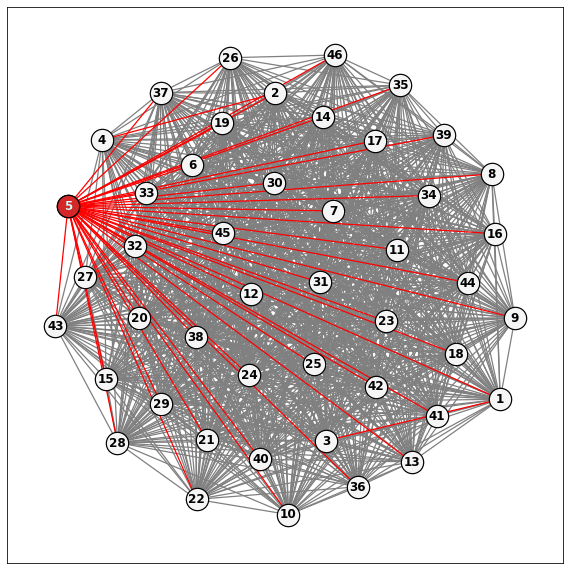

In [63]:
# RENDERING MST INIZIALE SUL GRAFO
draw_graph(G, mst, ROOT_NODE)
save_figure(name="initial")

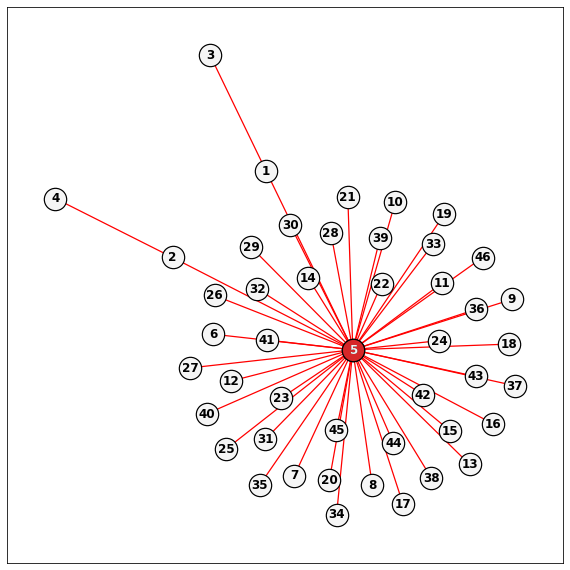

In [64]:
# RENDERING MST INIZIALE
draw_graph(mst, mst, ROOT_NODE)
save_figure(name="mst_initial")

### 2. Improvement

Miglioro per scambio di archi, con una strategia quasi greedy.

> Possibili miglioramenti?

* TODO parametrizzare e isolare in una funzione

* ~~TODO provare con grafi grossi~~ soluzioni parecchio subottimali (con 16 nodi, c=10 quando ottimo è c=0)
    * **[migliorato]** consentendo swap con archi eliminati (c=6)

* TODO preferire aggiunta di archi incidenti in nodi foglia?

In [65]:
# calcolo il grafo complementare all'MST
outer_G = G.copy()
outer_G.remove_edges_from(mst.edges)
#draw_graph(outer_G, root_node=ROOT_NODE)

candidates = list(outer_G.edges)
k = 0

if DEBUG_IMPROVEMENT:
    print("NON IN MST:", outer_G.edges)
    print("MST:", mst.edges)

    plt.figure(0)
    plt.title("Initial")
    draw_graph(G, mst, root_node=ROOT_NODE)
    if "SAVE_STEPS_GRAPH" in globals() and SAVE_STEPS_GRAPH:
        plt.savefig( os.path.join(OUT_DIR, "debug_Steps",'iter_{}'.format(k)) )


In [66]:
# CICLO DI MIGLIORAMENTO

# aggiungo un arco all'MST
# ciò causerà la nascita di un ciclo nel grafo, perchè MST è sottinsieme massimale di archi senza cicli
# quindi elimino un arco del ciclo che si è venuto a creare <=> la funzione obiettivo migliora

#for new_e in candidates:
iter = 0
while len(candidates) > 0 and iter < MAX_ITER:
    iter += 1
    new_e = candidates.pop(0)
    cost_before = cost(mst, ROOT_NODE)

    # Se sono così fortunato da aver trovato la soluzione ottima,
    # ferma tutto (non si può mai migliorare più di così)
    if cost_before == 0:
        break
    if DEBUG_IMPROVEMENT:
        print("")
        print(k,") initial cost: ",cost_before)
        print("MST=", list(mst.edges))
        print("add: ",new_e)

    mst.add_edges_from([new_e])

    # loop detection
    loop_edges = nx.algorithms.cycles.find_cycle(mst)


    cost_improved = False
    # 1: eliminazione GREEDY dell'arco in più
    # scelgo la mossa che localmente mi da l'abbassamento minore di obj()
    for ce in [e for e in loop_edges if e != new_e]:
        #print(k,"MST=",mst.edges); 
        k+=1;
        cost_before = cost(mst, ROOT_NODE)
        mst.remove_edges_from([ce])
        
        if DEBUG_IMPROVEMENT:
            fig = plt.figure(k)
            plt.title("add: {}, remove: {}".format(new_e, ce))
            draw_graph(G, mst, root_node=ROOT_NODE )
            if "SAVE_STEP_GRAPHS" in globals() and SAVE_STEP_GRAPHS:
                plt.savefig(os.path.join(OUT_DIR,"debug_Steps",'iter_{}'.format(k)))
            print("remove: ", ce)
            
        cost_after = cost(mst, ROOT_NODE)

        if cost_after > cost_before:
            # annulla e prova a rimuovere un altro arco
            mst.add_edges_from([ce])
            if DEBUG_IMPROVEMENT:
                print("new cost: ",cost_after, "(revert)")
        else:
            # rendi la modifica permanente e passa oltre.
            # non esploro gli altri archi candidati per lo scambio 
            # perchè con una mossa del genere
            # il costo può essere ridotto solo di 1
            if DEBUG_IMPROVEMENT:
                print("new cost: ",cost_after, "(keep)")
            cost_improved = True

            # Se e solo se l'arco rimosso forniva una soluzione equivalente,
            # lo (ri)metto nell'insieme dei candidati
            # nel caso mi serva per migliorare più avanti
            # (lo metto in fondo alla lista per 
            #  dare priorità alle sostituzioni non ancora tentate)
            if cost_after == cost_before:
                candidates.append(ce)


            break

        # se non ci sono stati miglioramenti, 
        # rimuovi l'arco aggiunto e provane un altro
        if not cost_improved:
            if DEBUG_IMPROVEMENT:
                print("No improvements, removing: ",new_e)
            mst.remove_edges_from([new_e])
            candidates.append(new_e)


### 3. Risultati


In [67]:
# PRINT RESULTS
print("Costo finale: ", cost(mst, ROOT_NODE))
print("MST = ",mst.edges)

print("")
print("---STATISTICHE---")
print("Iterazioni eseguite: {}/{}".format(iter,MAX_ITER))
print("Figli nodi non ottimali: ",[{n: x-(ROOT_NODE!=n)*1} for (n,x) in mst.degree() if x > 2])
V = G.number_of_nodes()
E = G.number_of_edges()
print("|V| = ", V)
print("|E| = ", E)



print("")
print("---TEST AMMISSIBILITA'---")

print("graph is complete: ",(E == V*(V-1)/2))

print("mst is tree: ",nx.is_tree(mst))

try:
    cycletest = nx.algorithms.cycles.find_cycle(mst, orientation="ignore")
except:
    cycletest = None
finally:
    print("mst loops: ", cycletest)


Costo finale:  12
MST =  [(5, 44), (1, 3), (1, 42), (2, 41), (6, 9), (6, 43), (6, 32), (6, 16), (7, 44), (7, 10), (8, 11), (8, 4), (10, 4), (11, 14), (12, 35), (13, 21), (14, 17), (15, 18), (17, 30), (17, 25), (18, 23), (18, 28), (19, 37), (19, 31), (19, 25), (20, 24), (20, 29), (20, 34), (21, 26), (22, 27), (22, 26), (26, 31), (28, 34), (29, 32), (29, 35), (31, 34), (33, 38), (33, 36), (35, 40), (35, 38), (36, 39), (37, 41), (39, 42), (43, 45), (45, 46)]

---STATISTICHE---
Iterazioni eseguite: 2988/36000
Figli nodi non ottimali:  [{6: 3}, {17: 2}, {18: 2}, {19: 2}, {20: 2}, {26: 2}, {29: 2}, {31: 2}, {34: 2}, {35: 3}]
|V| =  46
|E| =  1031

---TEST AMMISSIBILITA'---
graph is complete:  False
mst is tree:  True
mst loops:  None


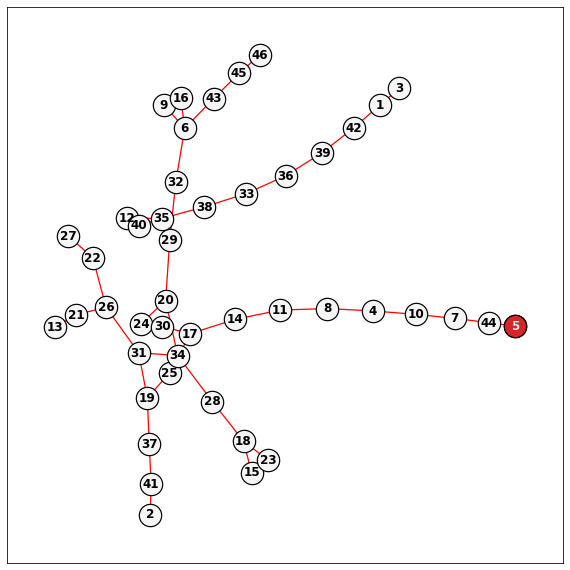

In [68]:
# RENDERING MST
draw_graph(mst, mst, ROOT_NODE)
save_figure(name="mst_final")

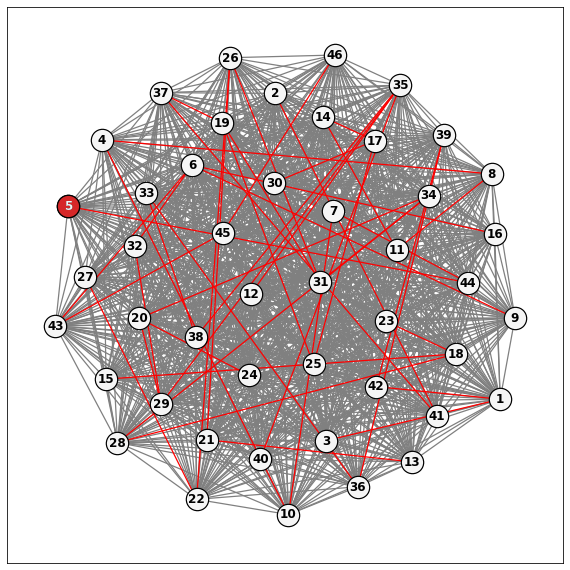

In [69]:
# RENDERING MST SOPRA AL GRAFO
draw_graph(G, mst, ROOT_NODE)
save_figure(name="final")